**Link to Google Drive**

In [ ]:
#Giving Permission to notebook to access Drive
from google.colab import drive
import os

# Function to mount Google Drive and handle errors
def mount_drive():
    try:
        print("Mounting Google Drive...")
        drive.mount('/content/drive')  # Attempt to mount Google Drive

        # Check if the mount was successful by verifying the existence of a file in the drive
        drive_check_path = '/content/drive/My Drive/Colab Files/Output/'
        if not os.path.exists(drive_check_path):
            raise FileNotFoundError(f"Google Drive is not mounted properly. Please check for the drive path {drive_check_path} and try again.")

        print("Google Drive mounted successfully!")
    except Exception as e:
        print(f"Error while mounting Google Drive: {e}")

# Call the function to mount Google Drive
mount_drive()

Mounting Google Drive...
Mounted at /content/drive
Google Drive mounted successfully!


**Loading the csv file, Training(80%) and Testing(20%)**

CSV Files --> ['sentiment_sarcasm_reviews_3500.csv']
Folder Path --> /content/drive/My Drive/Colab Files/Output/
Files in the folder --> ['translated_sentiment_labeled_2025-04-20_15-25-23.csv', 'translated_sentiment_labeled_2025-04-21_16-09-01.csv', 'translated_sentiment_labeled_2025-04-21_16-25-06.csv', 'translated_sentiment_labeled_2025-04-21_17-45-26.csv', 'multilingual_sarcastic_reviews_2000.csv', 'multilingual_sarcastic_reviews_200.csv', 'multilingual_sarcastic_reviews_500.csv', '500', 'sentiment_sarcasm_reviews_3500.csv']
The latest file is: sentiment_sarcasm_reviews_3500.csv
Full Address -----> /content/drive/My Drive/Colab Files/Output/sentiment_sarcasm_reviews_3500.csv


Epoch 1: 100%|██████████| 175/175 [01:14<00:00,  2.36it/s]


Epoch 1 Loss: 0.6934 | Accuracy: 0.9704


Epoch 2: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 2 Loss: 0.1944 | Accuracy: 1.0000


Epoch 3: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 3 Loss: 0.1019 | Accuracy: 1.0000


Epoch 4: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 4 Loss: 0.0633 | Accuracy: 1.0000


Epoch 5: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 5 Loss: 0.0504 | Accuracy: 0.9996


Epoch 6: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 6 Loss: 0.0338 | Accuracy: 1.0000


Epoch 7: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 7 Loss: 0.0240 | Accuracy: 1.0000


Epoch 8: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 8 Loss: 0.0184 | Accuracy: 1.0000


Epoch 9: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 9 Loss: 0.0198 | Accuracy: 0.9996


Epoch 10: 100%|██████████| 175/175 [01:13<00:00,  2.39it/s]


Epoch 10 Loss: 0.0120 | Accuracy: 1.0000
✅ Model saved to /content/drive/MyDrive/Colab Notebooks/multitask_sentiment_sarcasm_review.pt
Accuracy: 1.0
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       311
         1.0       1.00      1.00      1.00       389

    accuracy                           1.00       700
   macro avg       1.00      1.00      1.00       700
weighted avg       1.00      1.00      1.00       700



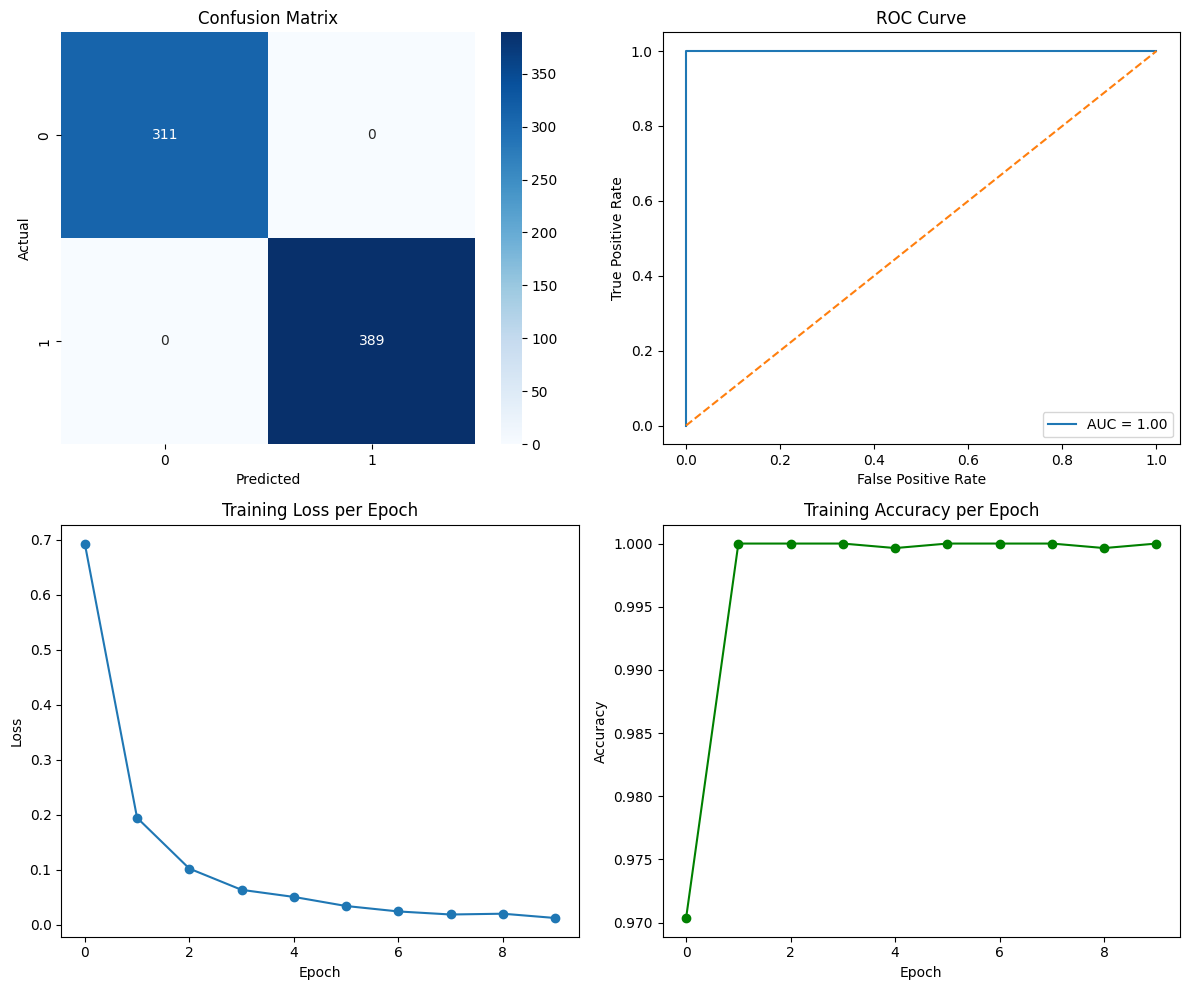

In [ ]:
from google.colab import drive
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, AutoModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt
from tqdm import tqdm

# Define the directory on Google Drive where the file is stored
folder_path = '/content/drive/My Drive/Colab Files/Output/'

# List all files in the folder
files = os.listdir(folder_path)

# Filter files that start with the prefix and end with ".csv"
csv_files = [file for file in files if file.startswith('sentiment_sarcasm_reviews_') and file.endswith('.csv')]
print("CSV Files -->", csv_files)

# Sort files by modification time to get the latest one
csv_files.sort(key=lambda x: os.path.getmtime(os.path.join(folder_path, x)), reverse=True)

# The latest file is the first in the sorted list
latest_file = csv_files[0]

# Define the full path to the latest file
latest_file_path = os.path.join(folder_path, latest_file)

print("Folder Path -->", folder_path)
print("Files in the folder -->", files)
print(f"The latest file is: {latest_file}")
print(f"Full Address -----> {latest_file_path}")

# Load the DataFrame from the latest CSV file
df = pd.read_csv(latest_file_path)

# Drop missing and map labels
df = df.dropna(subset=["Review", "Sentiment", "Sarcasm"])
df["Sentiment"] = df["Sentiment"].map({"Positive": 1, "Negative": 0})
df["Sarcasm"] = df["Sarcasm"].map({"Yes": 1, "No": 0})

# Tokenizer and model base
model_name = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)
encoder_model = AutoModel.from_pretrained(model_name)

# Dataset
class MultiTaskDataset(Dataset):
    def __init__(self, texts, sentiments, sarcasms, tokenizer, max_len=128):
        self.texts = texts
        self.sentiments = sentiments
        self.sarcasms = sarcasms
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer.encode_plus(
            self.texts[idx],
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        return {
            "input_ids": encoding["input_ids"].squeeze(0),
            "attention_mask": encoding["attention_mask"].squeeze(0),
            "sentiment_label": torch.tensor(self.sentiments[idx], dtype=torch.float),
            "sarcasm_label": torch.tensor(self.sarcasms[idx], dtype=torch.float)
        }

# Model
class MultiTaskModel(nn.Module):
    def __init__(self, encoder, hidden_dim=128):
        super(MultiTaskModel, self).__init__()
        self.encoder = encoder
        self.lstm = nn.LSTM(input_size=encoder.config.hidden_size, hidden_size=hidden_dim,
                            batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(hidden_dim * 2, 64)
        self.sentiment_out = nn.Linear(64, 1)
        self.sarcasm_out = nn.Linear(64, 1)

    def forward(self, input_ids, attention_mask):
        enc_output = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        x, _ = self.lstm(enc_output.last_hidden_state)
        attn_weights = torch.softmax(self.attn(x), dim=1)
        x = torch.sum(attn_weights * x, dim=1)
        x = self.dropout(x)
        x = torch.relu(self.dense(x))
        return self.sentiment_out(x), self.sarcasm_out(x)

# Prepare data
X_train, X_test, y_train_sent, y_test_sent, y_train_sarc, y_test_sarc = train_test_split(
    df["Review"].tolist(), df["Sentiment"].tolist(), df["Sarcasm"].tolist(),
    test_size=0.2, random_state=42
)

train_dataset = MultiTaskDataset(X_train, y_train_sent, y_train_sarc, tokenizer)
test_dataset = MultiTaskDataset(X_test, y_test_sent, y_test_sarc, tokenizer)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16)

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MultiTaskModel(encoder_model).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-5)
criterion = nn.BCEWithLogitsLoss()


train_losses, train_accuracies = [], []
for epoch in range(10):
    model.train()
    total_loss = 0
    correct_preds = 0
    total_preds = 0

    for batch in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        sentiment_labels = batch["sentiment_label"].to(device).unsqueeze(1)
        sarcasm_labels = batch["sarcasm_label"].to(device).unsqueeze(1)

        optimizer.zero_grad()
        sent_out, sarc_out = model(input_ids, attention_mask)
        sent_loss = criterion(sent_out, sentiment_labels)
        sarc_loss = criterion(sarc_out, sarcasm_labels)
        loss = sent_loss + sarc_loss
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        preds = (torch.sigmoid(sent_out) > 0.5).float()
        correct_preds += (preds == sentiment_labels).sum().item()
        total_preds += sentiment_labels.size(0)

    avg_loss = total_loss / len(train_loader)
    acc = correct_preds / total_preds
    train_losses.append(avg_loss)
    train_accuracies.append(acc)
    print(f"Epoch {epoch+1} Loss: {avg_loss:.4f} | Accuracy: {acc:.4f}")
# Save model
model_path = "/content/drive/MyDrive/Colab Notebooks/multitask_sentiment_sarcasm_review.pt"
torch.save(model.state_dict(), model_path)
print(f"✅ Model saved to {model_path}")
# Evaluation & Visualization
from sklearn.metrics import (classification_report, precision_score,
recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve)
import seaborn as sns

# Evaluate on test set
model.eval()
all_preds, all_probs, all_labels = [], [], []
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["sentiment_label"].to(device).unsqueeze(1)
        out, _ = model(input_ids, attention_mask)
        probs = torch.sigmoid(out).cpu().numpy()
        preds = (probs > 0.5).astype(int)
        all_preds.extend(preds.flatten())
        all_probs.extend(probs.flatten())
        all_labels.extend(labels.cpu().numpy().flatten())

print("Accuracy:", accuracy_score(all_labels, all_preds)) # Use all_preds which contains class labels (0 or 1)
print(classification_report(all_labels, all_preds))

from sklearn.metrics import accuracy_score
accuracy = accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, zero_division=0)
recall = recall_score(all_labels, all_preds, zero_division=0)
f1 = f1_score(all_labels, all_preds, zero_division=0)
cm = confusion_matrix(all_labels, all_preds)
fpr, tpr, _ = roc_curve(all_labels, all_probs)
auc_score = roc_auc_score(all_labels, all_probs)

# Visuals
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axs[0, 0])
axs[0, 0].set_title("Confusion Matrix")
axs[0, 0].set_xlabel("Predicted")
axs[0, 0].set_ylabel("Actual")

axs[0, 1].plot(fpr, tpr, label=f"AUC = {auc_score:.2f}")
axs[0, 1].plot([0, 1], [0, 1], linestyle='--')
axs[0, 1].set_title("ROC Curve")
axs[0, 1].set_xlabel("False Positive Rate")
axs[0, 1].set_ylabel("True Positive Rate")
axs[0, 1].legend()

axs[1, 0].plot(train_losses, marker='o')
axs[1, 0].set_title("Training Loss per Epoch")
axs[1, 0].set_xlabel("Epoch")
axs[1, 0].set_ylabel("Loss")

axs[1, 1].plot(train_accuracies, marker='o', color='green')
axs[1, 1].set_title("Training Accuracy per Epoch")
axs[1, 1].set_xlabel("Epoch")
axs[1, 1].set_ylabel("Accuracy")

plt.tight_layout()
plt.show()


**Gradio Interface**

In [ ]:
!pip install gradio deep_translator langdetect transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 17.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.9/322.9 kB 23.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.3/42.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.8/132.8 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 131.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.

In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from transformers import AutoTokenizer, AutoModel
from langdetect import detect
from deep_translator import GoogleTranslator
import gradio as gr
import os
from datetime import datetime

# ✅ Translation utility
def translate_if_needed(text):
    try:
        lang = detect(text)
        if lang != 'en':
            return GoogleTranslator(source='auto', target='en').translate(text)
    except:
        pass
    return text

# ✅ Load tokenizer and encoder
tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-base")
encoder_model = AutoModel.from_pretrained("xlm-roberta-base")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ✅ Multitask model with sentiment + sarcasm
class MultiTaskModel(nn.Module):
    def __init__(self, encoder, hidden_dim=128):
        super().__init__()
        self.encoder = encoder
        self.lstm = nn.LSTM(input_size=encoder.config.hidden_size, hidden_size=hidden_dim,
                             batch_first=True, bidirectional=True)
        self.attn = nn.Linear(hidden_dim * 2, 1)
        self.dropout = nn.Dropout(0.3)
        self.dense = nn.Linear(hidden_dim * 2, 64)
        self.sentiment_out = nn.Linear(64, 1)
        self.sarcasm_out = nn.Linear(64, 1)

    def forward(self, input_ids, attention_mask):
        enc = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        lstm_out, _ = self.lstm(enc.last_hidden_state)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)
        context_vector = torch.sum(attn_weights * lstm_out, dim=1)
        x = self.dropout(context_vector)
        x = torch.relu(self.dense(x))
        return self.sentiment_out(x), self.sarcasm_out(x)

# ✅ Load trained multitask model
model = MultiTaskModel(encoder_model).to(device)
model_path = "/content/drive/MyDrive/Colab Notebooks/multitask_sentiment_sarcasm_review.pt"
model.load_state_dict(torch.load(model_path, map_location=device))
model.eval()

# ✅ Main function for both input modes
def analyze_sentiment_and_sarcasm(mode, text, file, threshold):
    results = []
    if mode == "Text Input":
        original_text = text.strip()
        if not original_text:
            return pd.DataFrame([{"Error": "❌ Please enter some text."}])

        translated = translate_if_needed(original_text)
        encoding = tokenizer.encode_plus(
            translated,
            add_special_tokens=True,
            max_length=128,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            return_tensors="pt"
        )
        input_ids = encoding["input_ids"].to(device)
        attention_mask = encoding["attention_mask"].to(device)

        with torch.no_grad():
            sentiment_out, sarcasm_out = model(input_ids=input_ids, attention_mask=attention_mask)
            sentiment_prob = torch.sigmoid(sentiment_out).squeeze().item()
            sarcasm_prob = torch.sigmoid(sarcasm_out).squeeze().item()

        pred = 1 if sentiment_prob > threshold else 0
        sentiment = "Positive" if pred == 1 else "Negative"
        is_sarcastic = sarcasm_prob > 0.5

        if is_sarcastic:
            if sentiment == "Positive":
                sentiment = "Sarcastic ➝ Negative"
                sentiment_prob = 1 - sentiment_prob
            elif sentiment == "Negative":
                sentiment = "Negative (Sarcastic)"

        results.append({
            "Original Review": original_text,
            "Translated Review": translated,
            "Predicted Sentiment": sentiment,
            "Confidence": round(sentiment_prob if pred == 1 else 1 - sentiment_prob, 4),
            "Raw Probability": round(sentiment_prob, 4),
            "Sarcasm Detected": "Yes" if is_sarcastic else "No"
        })
        return pd.DataFrame(results)

    elif mode == "File Upload":
        try:
            df = pd.read_csv(file.name)
        except Exception as e:
            return pd.DataFrame([{"Error": f"❌ Failed to read CSV: {e}"}])

        if "Review" not in df.columns:
            return pd.DataFrame([{"Error": "❌ CSV must contain a column named 'Review'."}])

        for original_text in df["Review"].dropna().tolist():
            translated = translate_if_needed(original_text)
            encoding = tokenizer.encode_plus(
                translated,
                add_special_tokens=True,
                max_length=128,
                padding="max_length",
                truncation=True,
                return_attention_mask=True,
                return_tensors="pt"
            )
            input_ids = encoding["input_ids"].to(device)
            attention_mask = encoding["attention_mask"].to(device)

            with torch.no_grad():
                sentiment_out, sarcasm_out = model(input_ids=input_ids, attention_mask=attention_mask)
                sentiment_prob = torch.sigmoid(sentiment_out).squeeze().item()
                sarcasm_prob = torch.sigmoid(sarcasm_out).squeeze().item()

            pred = 1 if sentiment_prob > threshold else 0
            sentiment = "Positive" if pred == 1 else "Negative"
            is_sarcastic = sarcasm_prob > 0.5

            if is_sarcastic:
                if sentiment == "Positive":
                    sentiment = "Sarcastic ➝ Negative"
                    sentiment_prob = 1 - sentiment_prob
                elif sentiment == "Negative":
                    sentiment = "Negative (Sarcastic)"

            results.append({
                "Original Review": original_text,
                "Translated Review": translated,
                "Predicted Sentiment": sentiment,
                "Confidence": round(sentiment_prob if pred == 1 else 1 - sentiment_prob, 4),
                "Raw Probability": round(sentiment_prob, 4),
                "Sarcasm Detected": "Yes" if is_sarcastic else "No"
            })

        output_df = pd.DataFrame(results)
        output_dir = "/content/drive/MyDrive/sentiment_outputs/"
        os.makedirs(output_dir, exist_ok=True)
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        file_name = f"translated_predicted_sentiments_{timestamp}.csv"
        output_path = os.path.join(output_dir, file_name)
        output_df.to_csv(output_path, index=False)
        return output_df

# ✅ Gradio UI with text or file input
gr.Interface(
    fn=analyze_sentiment_and_sarcasm,
    inputs=[
        gr.Radio(["Text Input", "File Upload"], label="Choose Input Mode", value="Text Input"),
        gr.Textbox(label="Enter Review (only for Text Input mode)", lines=3),
        gr.File(label="Upload CSV with 'Review' column (only for File Upload mode)"),
        gr.Slider(0.1, 0.9, step=0.01, value=0.5, label="Sentiment Threshold")
    ],
    outputs=gr.Dataframe(headers=["Original Review", "Translated Review", "Predicted Sentiment", "Confidence", "Raw Probability", "Sarcasm Detected"]),
    title="Multilingual Sentiment & Sarcasm Detector",
    description="Choose between manual text input or CSV upload to detect sentiment and sarcasm."
).launch()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/615 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.07M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.10M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://8968e24ba7e7946c3f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
